In [1]:
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [1]:
!pip install evaluate
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset('yangwang825/reuters-21578')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/yangwang825___json/yangwang825--reuters-21578-7a62a981513ce198/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer

tokenizer_xlnet = AutoTokenizer.from_pretrained('xlnet-base-cased')

In [4]:
def tokenize_function_xlnet(examples):
    return tokenizer_xlnet(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets_xlnet = dataset.map(tokenize_function_xlnet, batched=True)

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/2189 [00:00<?, ? examples/s]

In [7]:
small_train_dataset_xlnet = tokenized_datasets_xlnet['train'].shuffle(seed=42).select(range(1000))
small_eval_dataset_xlnet = tokenized_datasets_xlnet['test'].shuffle(seed=42).select(range(1000))

In [8]:
from transformers import AutoModelForSequenceClassification

model_xlnet = AutoModelForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=8)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [9]:
from transformers import TrainingArguments, Trainer

training_args_xlnet = TrainingArguments(output_dir="test_trainer_xlnet", evaluation_strategy="epoch", num_train_epochs=4,
                                      per_device_train_batch_size=8, per_device_eval_batch_size=8)

In [10]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
trainer_xlnet = Trainer(
    model=model_xlnet,
    args=training_args_xlnet,
    train_dataset=small_train_dataset_xlnet,
    eval_dataset=small_eval_dataset_xlnet,
    compute_metrics=compute_metrics,
)

In [12]:
trainer_xlnet.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.356312,0.858000
2,No log,0.140455,0.965000
3,No log,0.101059,0.978000
4,0.274200,0.113867,0.977000


TrainOutput(global_step=500, training_loss=0.2742103271484375, metrics={'train_runtime': 1294.3796, 'train_samples_per_second': 3.09, 'train_steps_per_second': 0.386, 'total_flos': 1139577815040000.0, 'train_loss': 0.2742103271484375, 'epoch': 4.0})

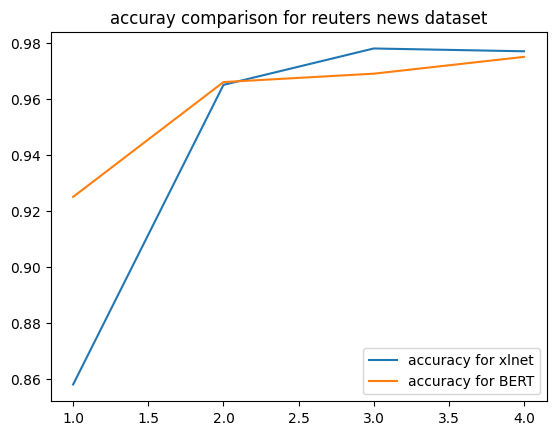

In [14]:
import matplotlib.pyplot as plt

x = range(1, 5)
y_xlnet = [0.858000, 0.965000, 0.978000, 0.977000]
y_bert = [0.925000, 0.966000, 0.969000, 0.975000]
plt.plot(x, y_xlnet, label='accuracy for xlnet')
plt.plot(x, y_bert, label='accuracy for BERT')
plt.title('accuray comparison for reuters news dataset')
plt.legend()
plt.show()